In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# pre processing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
#from imblearn.under_sampling import TomekLinks # down sampling
#from imblearn.over_sampling import SMOTE # up sampling


# model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm


# Model Validation 
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# statistical testing
from scipy.stats import f_oneway
from scipy import stats

sns.set_style('whitegrid')

%matplotlib inline

In [89]:
# import data
us_shape = gpd.read_file('../../src/data/cb_2018_us_state_500k.shp')

df = pd.read_csv('../../src/csv/final_dataframe_graphing.csv')
df_model = pd.read_csv('../../src/csv/final_dataframe.csv')
us_shape.STATEFP = us_shape.STATEFP.astype(int)


In [90]:
us_shape

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


# Colinearity Between covid and population 

Covid data and population data are heavily correlated


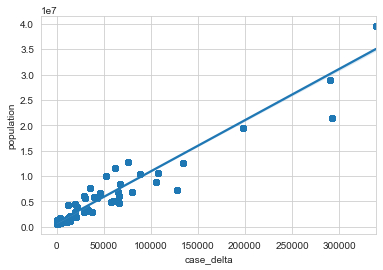

In [91]:
sns.regplot(data=df_model, x="case_delta", y="population")

In [92]:
X = df_model.population
y = df_model.case_delta
results = sm.OLS(X,y).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             population   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.059e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        14:41:28   Log-Likelihood:                         -63552.
No. Observations:                3903   AIC:                                  1.271e+05
Df Residuals:                    3902   BIC:                                  1.271e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Filtered out the noise by subtracting the mean of the state target.

In [134]:

target_sum_state = df.groupby(["GESTFIPS"]).target.sum().reset_index()

us_shape_target = us_shape.merge(target_sum_state, left_on='STATEFP', right_on='GESTFIPS', how='inner')
us_shape_target.target = us_shape_target.target/us_shape_target.target.sum() * 100

In [94]:
us_shape_target.target = us_shape_target.target - us_shape_target.target.median()
us_shape_target.target = [x if x > 0 else 0 for x in us_shape_target.target]

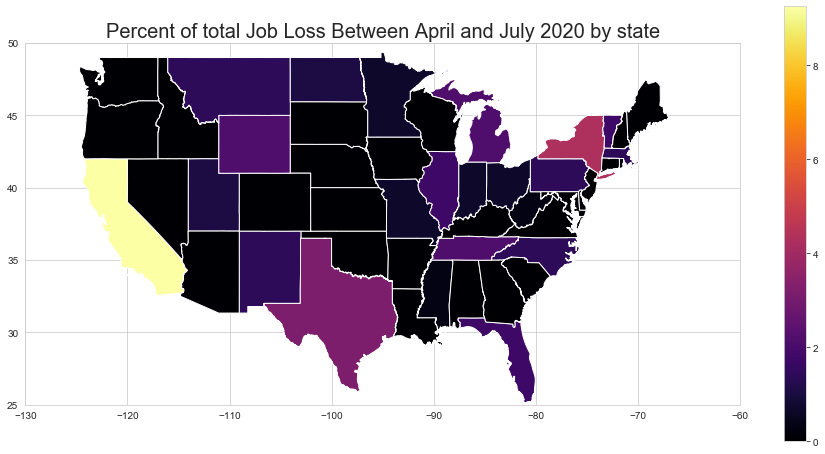

In [95]:
merged = us_shape_target.copy()
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

fig, ax = plt.subplots(figsize = (16,8))
merged.plot(ax=ax,
                         alpha = 1,
                         column='target',
                         cmap = 'inferno',
                         legend=True)
ax.set_ylim(25,50)
ax.set_xlim(-130,-60)
ax.set_title("Percent of total Job Loss Between April and July 2020 by state", size=20);
fig.savefig('../../images/job_loss_state.png', bbox_inches='tight')

# Covid data by state

In [96]:
target_sum_delta = df.groupby(["GESTFIPS"]).case_delta.sum().reset_index()


us_shape_delta = us_shape.merge(target_sum_delta, left_on='STATEFP', right_on='GESTFIPS', how='inner')


us_shape_delta.case_delta = us_shape_delta.case_delta/us_shape_delta.case_delta.sum() * 100

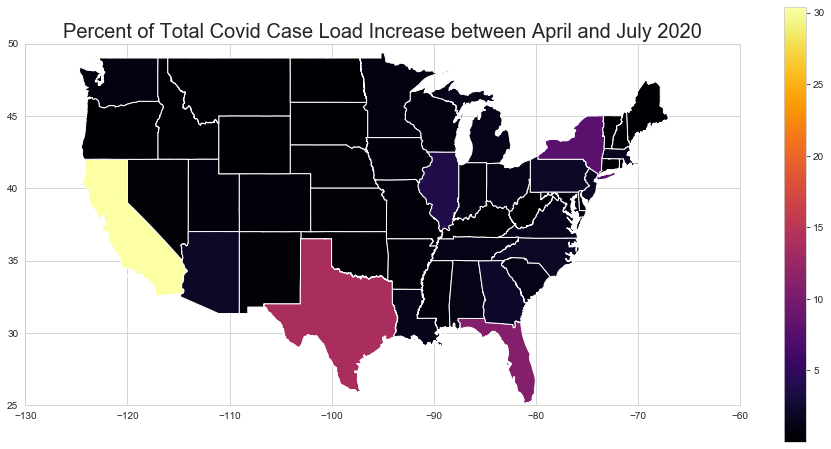

In [97]:
merged = us_shape_delta.copy()
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

fig, ax = plt.subplots(figsize = (16,8))
merged.plot(ax=ax,
                         alpha = 1,
                         column='case_delta',
                         cmap = 'inferno',
                         legend=True)

ax.set_ylim(25,50)
ax.set_xlim(-130,-60)


# for idx, row in merged.iterrows():
#     plt.annotate(s=row['gov'], xy=row['coords'],horizontalalignment='center', color='white')
    
ax.set_title("Percent of Total Covid Case Load Increase between April and July 2020", size=20);
fig.savefig('../../images/case_delta_percent.png', bbox_inches='tight')

In [98]:
X = df_model.drop(columns = ['target', 'population'])
y = df_model.target

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

logReg = LogisticRegression(class_weight='balanced', solver='saga', penalty='l2', C=0.015)

logReg.fit(X_scaled, y)
y_hat = logReg.predict(X_scaled)
cmatrix = confusion_matrix(y,y_hat)
print(classification_report(y, y_hat))

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


              precision    recall  f1-score   support

           0       0.97      0.72      0.82      3622
           1       0.15      0.67      0.25       281

   micro avg       0.71      0.71      0.71      3903
   macro avg       0.56      0.69      0.54      3903
weighted avg       0.91      0.71      0.78      3903



/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


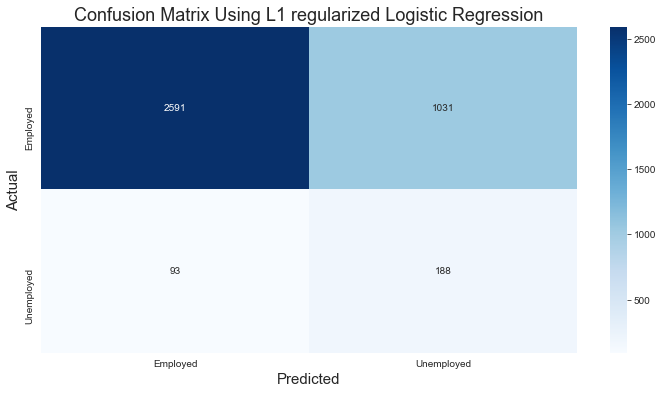

In [99]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xticklabels(['Employed', 'Unemployed'])
ax.set_yticklabels(['Employed', 'Unemployed'])
ax.set_ylabel('Actual', size=15)
ax.set_xlabel('Predicted', size=15)

ax.set_title('Confusion Matrix Using L1 regularized Logistic Regression', size =18)

fig.savefig('../../images/confusion_matrix.png', bbox_inches='tight')

Think this out. You want to plot population and job loss on the same x axis but with different y axis. 

first get a data frame with population and job_loss data



In [145]:
# population data
target_population_mean = df.groupby(["GESTFIPS"]).population.mean().reset_index()
target_population_mean.columns = ['fip_x', 'population']

In [147]:
target_sum_state.columns = ['fip_y', 'Job Loss']

,fip_y,Job Loss
0,1,3
1,2,3
2,4,2
3,5,3
4,6,30
5,8,3
6,9,0
7,10,0
8,12,9
9,13,4


In [150]:
df_plot = pd.concat([target_population_mean,target_sum_state], axis=1).drop(columns=['fip_x'])

columns_names = ['Population', 'fip', 'Job Loss']

df_plot.columns = columns_names
df_plot.job_loss = df_plot['Job Loss']/df_plot['Job Loss'].sum()
df_plot = df_plot.sort_values(['Job Loss', 'Population'], ascending = False)
df_plot.head(3)


/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,Population,STATEFP,Job Loss
4,39512223.0,6,30
31,19453561.0,36,16
42,28995881.0,48,13


In [151]:

to_plot = df_plot.merge(us_shape, on='STATEFP', how='inner')[['STATEFP', 'NAME','Population', 'Job Loss']][:10]

to_plot.to_csv('../../src/csv/job_loss_covid.csv')

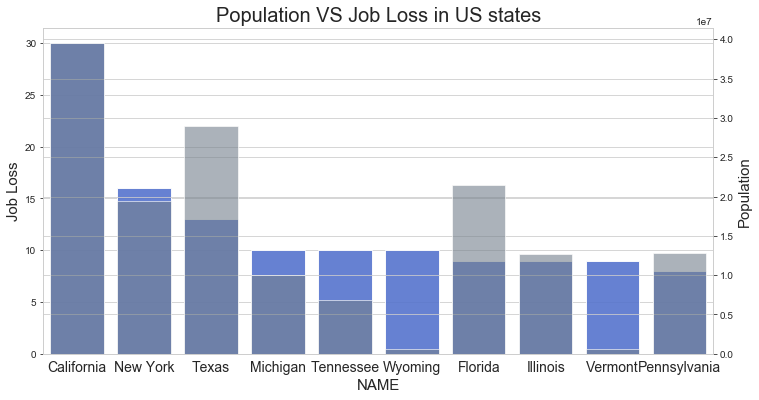

In [201]:
# Categorical plot examining the effect of genre on ROI
def plot():
    to_plot =pd.read_csv('../../src/csv/job_loss_covid.csv')
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # configure axis 1
    ax1.set_ylabel('Job Loss %', size = 15)
    ax1.set_xticklabels(labels = to_plot.NAME, size=14)
    ax1.set_xlabel('State', size = 15)
    ax1.set_label("Population")
    
    sns.barplot(data = to_plot, x='NAME', y='Job Loss', alpha=0.9, ax=ax1, color='royalblue')

    # configure axis 2
    ax2 = ax1.twinx()
    sns.barplot(data = to_plot, x='NAME', y='Population', alpha=0.6, ax=ax2, color='slategrey')
    ax2.set_ylabel('Population', size = 15)
    ax2.set_label("Population")
    
    # Set label
    ax1.set_title("Population VS Job Loss in US states" , size = 20)
    fig.savefig('../../images/population.png', bbox_inches='tight')
plot()

[1. 1. 1. ... 1. 1. 1.]


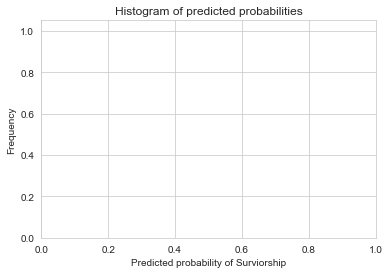

In [47]:
y_pred_prob = logReg.predict_proba(X)[:, 1]
plt.hist(y_pred_prob[0], bins=30,)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Surviorship')
plt.ylabel('Frequency')

In [30]:
fpr, tpr, thresholds =roc_curve(y, y_hat)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

NameError: name 'y' is not defined

In [29]:
fpr

NameError: name 'fpr' is not defined

In [63]:
coef_list = sorted(zip(X.columns.to_list(),logReg.coef_[0]), key=lambda x: x[1], reverse=True)
target_feature = [x[0] for x in coef_list][:10]
target_feature

['PRTAGE',
 'PTDTRACE_3',
 'case_delta',
 'PENATVTY',
 'PRAGNA',
 'PEMJOT',
 'PRMJOCC1_4',
 'PRMJIND1_6',
 'PRMJIND1_10',
 'HRNUMHOU']

In [ ]:
feature_names = [
    'Age',
    'Indiginous Descent',
    'Coronavirus Case Increase',
    'Born in the US',
    'Agricultural work force',
    'More than one Job',
    'Retail Workers',
    'Transportation Workers',
    'Education workers',
    ''
]

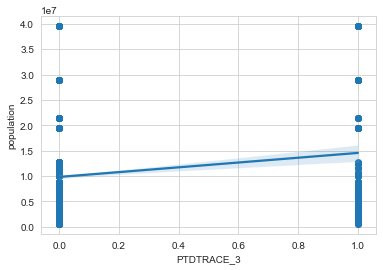

In [59]:
sns.regplot(data=df, x='PTDTRACE_3', y='population')